# Rainfall QC protocol for Personal Weather Stations

This notebook presents how to use the _flagging_-functions in the Python package `pypwsqc`, a quality assurance protocol developed for rainfall data from automated personal weather stations (PWS). 

The package is based on the original R code available at https://github.com/LottedeVos/PWSQC/.

[Publication: de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. Geophysical Research Letters, 46(15), 8820-8829](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731)

`pypwsqc` depends on the `poligrain`, `xarray`, `pandas` and `numpy` packages. Make sure to install and import the required packages first.

**Note that I am now placing the py module in the dir as the updated pypwsqc is not on pip. Please adjust when you have a working environment to distribute with the data. /L**

In [1]:
import numpy as np
import poligrain as plg
import xarray as xr
import matplotlib.pyplot as plt
import folium
import flagging # TODO: update

## Read data

In [2]:
ds_pws = xr.open_dataset("raw_OpenMRG_dataset_NetAtmo.nc")
ds_pws

<xarray.Dataset> Size: 2MB
Dimensions:    (id: 30, time: 8833)
Coordinates:
  * time       (time) datetime64[ns] 71kB 2015-06-01T00:15:00 ... 2015-09-01T...
  * id         (id) <U16 2kB 'Netatmo_SE000012' ... 'Netatmo_SE000400'
    latitude   (id) float64 240B ...
    longitude  (id) float64 240B ...
    x          (id) float64 240B ...
    y          (id) float64 240B ...
Data variables:
    rainfall   (id, time) float64 2MB ...
Attributes:
    title:                 OpenMRG PWS data
    file author:           Louise Petersson Wårdh
    institution:           Swedish Meteorological and Hydrological Institute
    date:                  2025-10-24
    source:                Netamo PWS
    history:               Data derived and reformatted from data received by...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             link to be added to Zenodo
    comment:               The projected x and y coordinates are in CRS SWERE...

### Map overview

We use the Python package `folium` to plot the locations of the PWS on OpenStreetMap.

In [3]:
lat = ds_pws.latitude.values
lon = ds_pws.longitude.values 
station_names = ds_pws.id.values
OpenMRG_map = folium.Map(location=[ds_pws.latitude.mean().item(), ds_pws.longitude.mean().item()], width = '75%', height = '75%', zoom_start=8)

for la, lo, station in zip(lat, lon, station_names):
    folium.CircleMarker(
        location=[la, lo],
        popup=station,
        tooltip=f"{station} ({la:.2f}, {lo:.2f})",
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(OpenMRG_map)

# Display
OpenMRG_map

### Create distance matrix

Calculate the distances between all stations in your data set. If your data set has a large number of stations this can take some time.

In [4]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Select range for neighbouring checks

The quality control is performed by comparing time series of each station with the time series of neighbouring stations within a specificed range `max_distance`. The selected range depends on the use case and area of interest. In this example, we use 10'000 meters. `max_distance` is called `d` in the [original publication](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731).

### Select considered range around each station

In [5]:
max_distance = 10e3

## Quality control

Now the data set is prepared to run the quality control.

### Faulty Zeros filter

Conditions for raising Faulty Zeros flag:

* Median rainfall of neighbouring stations within range max_distance is larger than zero for at least nint time intervals while the station itself reports zero rainfall.
* The FZ flag remains 1 until the station reports nonzero rainfall.
* Filter cannot be applied if less than `n_stat` neighbours are reporting data (FZ flag is set to -1)
* NOTE! The filter cannot be applied if the station has reported NaN data in the last `nint` time steps. This gives more -1 flags than in the original R-implementation that does not use this condition. This choice was done to ensure that timesteps without data at the evaluated station is not mistakenly being interpreted as timesteps who have passed the quality control (if they would have been flagged with 0) or as time steps with a Faulty Zero issue (if they would have been flagged with 1).
  
For settings for parameter `nint` and `n_stat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

#### Set FZ parameters

Note that we must set a lower value of `n_stat` than in the original publication, as the network density is lower in the Gothenburg area than in Amsterdam.

In [6]:
nint = 6
n_stat = 3

#### Run FZ filter

In [7]:
%%time

ds_pws_flagged = flagging.fz_filter(ds_pws, nint, n_stat, distance_matrix, max_distance)  # TODO: update

CPU times: total: 6.75 s
Wall time: 7.16 s


#### Inspect FZ flags for 9 example stations
Here we multiply the flag value with 10 for better visibility. The FZ filter cannot be applied (FZ flag == -1) for the whole period for Netatmo 111 and 112. This means that these stations have less than 3 neighbouring stations within 10 km distance. Netatmo 98 reports an erroneuos dry period in late July, and Netatmo 165 has intermittent FZ-flags throughout the whole evaluation period. Netatmo 167 reports faulty zeroes for more than 2 months, suggesting that this PWS was turned on but not installed properly during this period. After the installation, the station has no FZ flags.

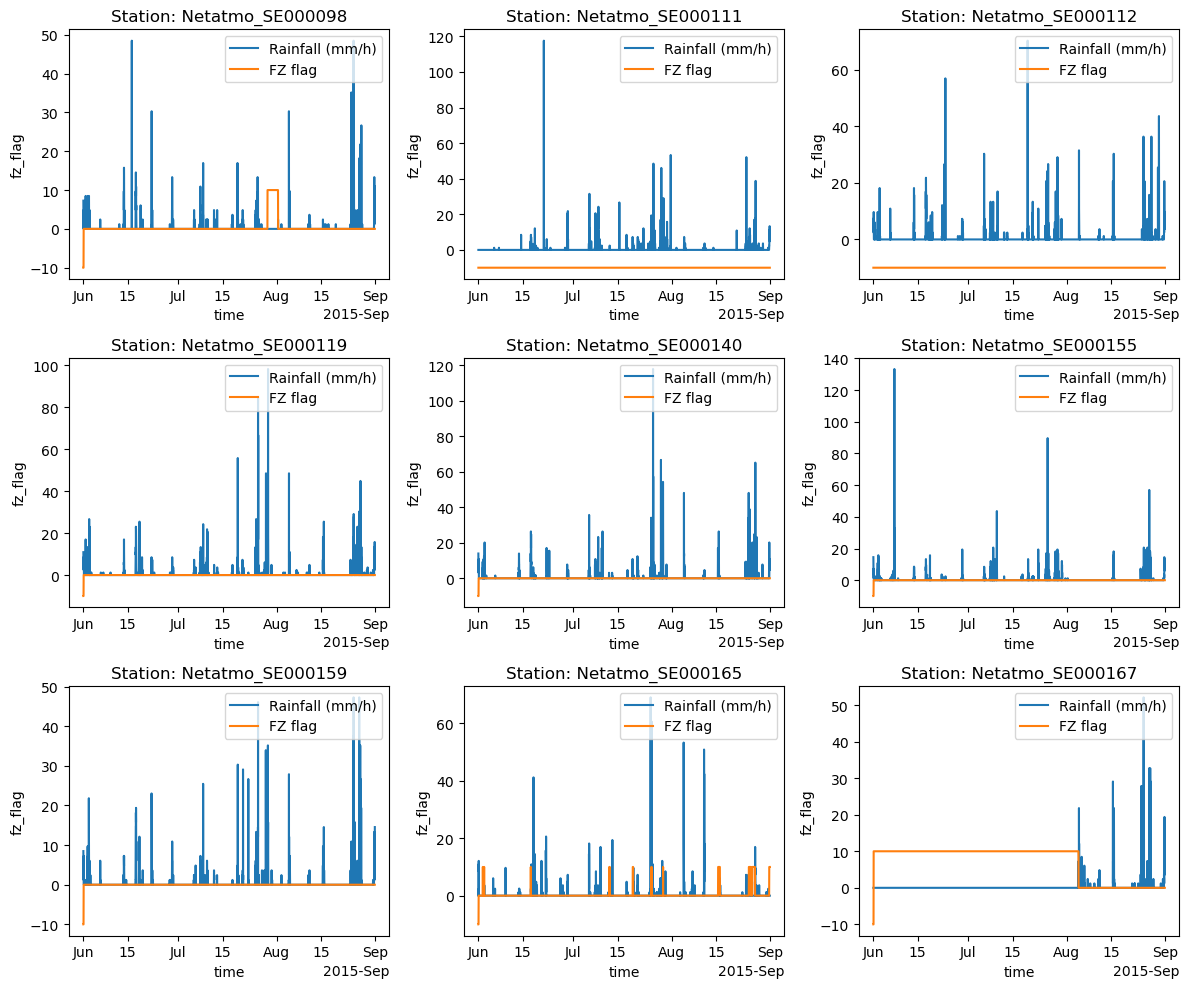

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.flatten()

for j, i in enumerate(np.arange(10, 19)):
    ax = axes[j]
    (ds_pws_flagged.rainfall.isel(id=i) * 12).plot(ax=ax, label="Rainfall (mm/h)")
    (ds_pws_flagged.fz_flag.isel(id=i) * 10).plot(ax=ax, label="FZ flag")
    ax.legend(loc = "upper right")   
    station_name = ds_pws_flagged.id.values[i]
    ax.set_title(f"Station: {station_name}")

plt.tight_layout()
plt.show()

#### Filter rainfall data based on FZ results

With this command we create a new variable called `flagged_rainfall` in the `xarray` dataset and remove all timesteps in the rainfall data that did not pass the filter. The resulting rainfall time series for Netatmo 167 is visualized as an example.

In [9]:
ds_pws_flagged["flagged_rainfall"] = ds_pws_flagged["rainfall"].where(ds_pws_flagged["fz_flag"] != 1)

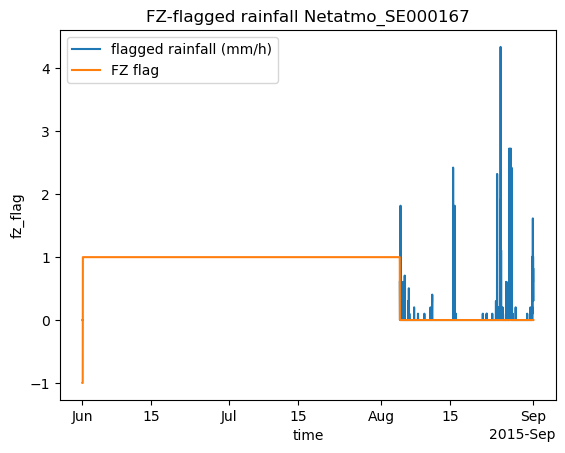

In [10]:
plt.figure()
ds_pws_flagged.flagged_rainfall.sel(id = 'Netatmo_SE000167', time = slice('2015-06-01','2015-09-01')).plot(label="flagged rainfall (mm/h)")
ds_pws_flagged.fz_flag.sel(id = 'Netatmo_SE000167').plot(label="FZ flag")
plt.title('FZ-flagged rainfall Netatmo_SE000167')
plt.legend()

## High Influx filter

Conditions for raising High Influx flag:

* If median rainfall of neighbours is below threshold ϕA, then high influx if rainfall above threshold ϕB
* If median rainfall of neighbours is above ϕA, then high influx if rainfall exceeds median times ϕB/ϕA
* Filter cannot be applied if less than n_stat neighbours are reporting data (HI flag is set to -1)
* NOTE! The filter cannot be applied if the station has reported NaN data in the last `nint` time steps. This gives more -1 flags than in the original R-implementation that does not use this condition. This choice was done to ensure that timesteps without data at the evaluated station is not mistakenly being interpreted as timesteps who have passed the quality control (if they would have been flagged with 0) or as time steps with a High Influx issue (if they would have been flagged with 1).
  
For settings for parameter ϕA, ϕB and n_stat, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

#### Set HI parameters

In [11]:
hi_thres_a=0.4
hi_thres_b=10
nint = 6
n_stat = 3

#### Run HI filter

In [12]:
%%time

ds_pws_flagged = flagging.hi_filter(ds_pws, hi_thres_a, hi_thres_b, nint, n_stat, distance_matrix, max_distance)  # TODO: update

CPU times: total: 62.5 ms
Wall time: 61.7 ms


#### Inspect HI flags for 9 example stations
We multiply the flag value with 10 for better visibility. Here we see that there are few high influx flags. Only Netatmo 155 gets one HI flag for 1 timestep on June 7. 

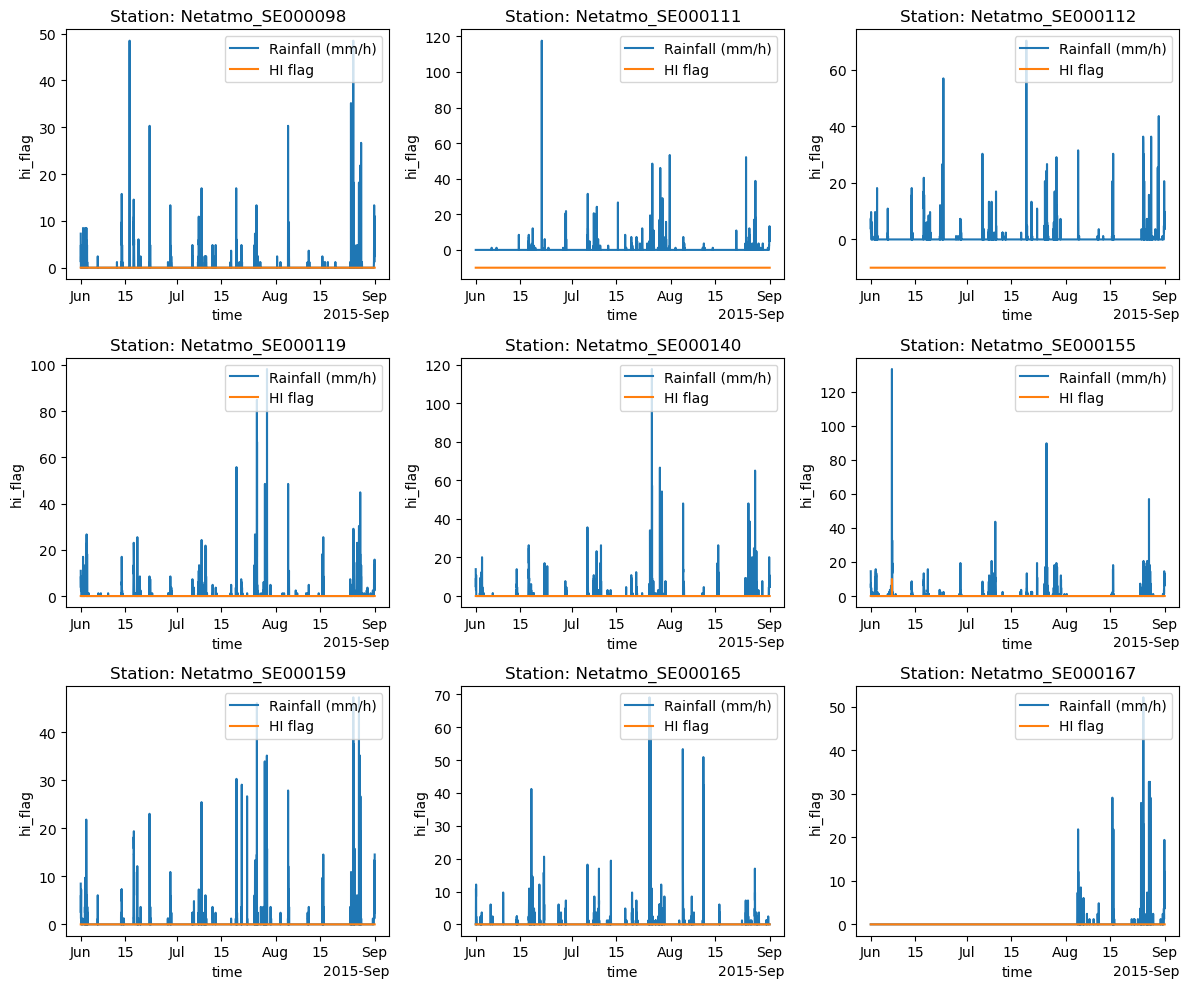

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.flatten()

for j, i in enumerate(np.arange(10, 19)):
    ax = axes[j]
    (ds_pws_flagged.rainfall.isel(id=i) * 12).plot(ax=ax, label="Rainfall (mm/h)")
    (ds_pws_flagged.hi_flag.isel(id=i) * 10).plot(ax=ax, label="HI flag")
    ax.legend(loc = "upper right")   
    station_name = ds_pws_flagged.id.values[i]
    ax.set_title(f"Station: {station_name}")

plt.tight_layout()
plt.show()

If we look at the overview map at the top of the notebook, we see that Netatmo 155 is in the vincinity of Netatmo 12, 25 and 277. Hover over the points on the map to see the station names and coordinates. Let's have a closer look at the rainfall time series of these stations on June 7. 

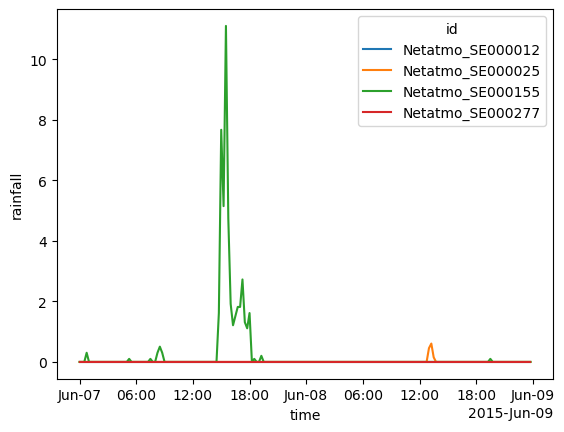

In [14]:
hi_stations = ['Netatmo_SE000012', 'Netatmo_SE000025', 'Netatmo_SE000155','Netatmo_SE000277']
plt.figure()
ds_pws.rainfall.sel(id=hi_stations, time = slice('2015-06-07','2015-06-08')).plot.line(x='time')

We see that the observations by Netatmo 155 exceeds 10 mm/5min in the afternoon of June 7, which raises a high influx flag as the neighbours report no rainfall at that time.  

## Station Outlier filter

#### Set SO parameters

In [25]:
evaluation_period = 4032
mmatch = 200
gamma = 0.15
n_stat = 3

#### Run SO filter

In [26]:
%%time

ds_pws_flagged = flagging.so_filter(
    ds_pws,
    evaluation_period,
    mmatch,
    gamma,
    n_stat,
    distance_matrix,
    max_distance
)

CPU times: total: 2.89 s
Wall time: 3.03 s


#### Inspect SO flags for 9 example stations

Here we multiply the flag value with 10 for better visibility. The SO filter cannot be applied (SO flag == -1) for the first month, as this is the warm-up period of the filter. The filter can then not be applied after July 15 for some stations because of dry time steps in the rolling evaluation period - refer to [de Vos et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731)
for details. We see that Netatmo 165 is flagged as Station Outlier whenever the filter can be applied. This station also got a lot of Faulty Zeroes flags and should probably be removed from any further analysis.

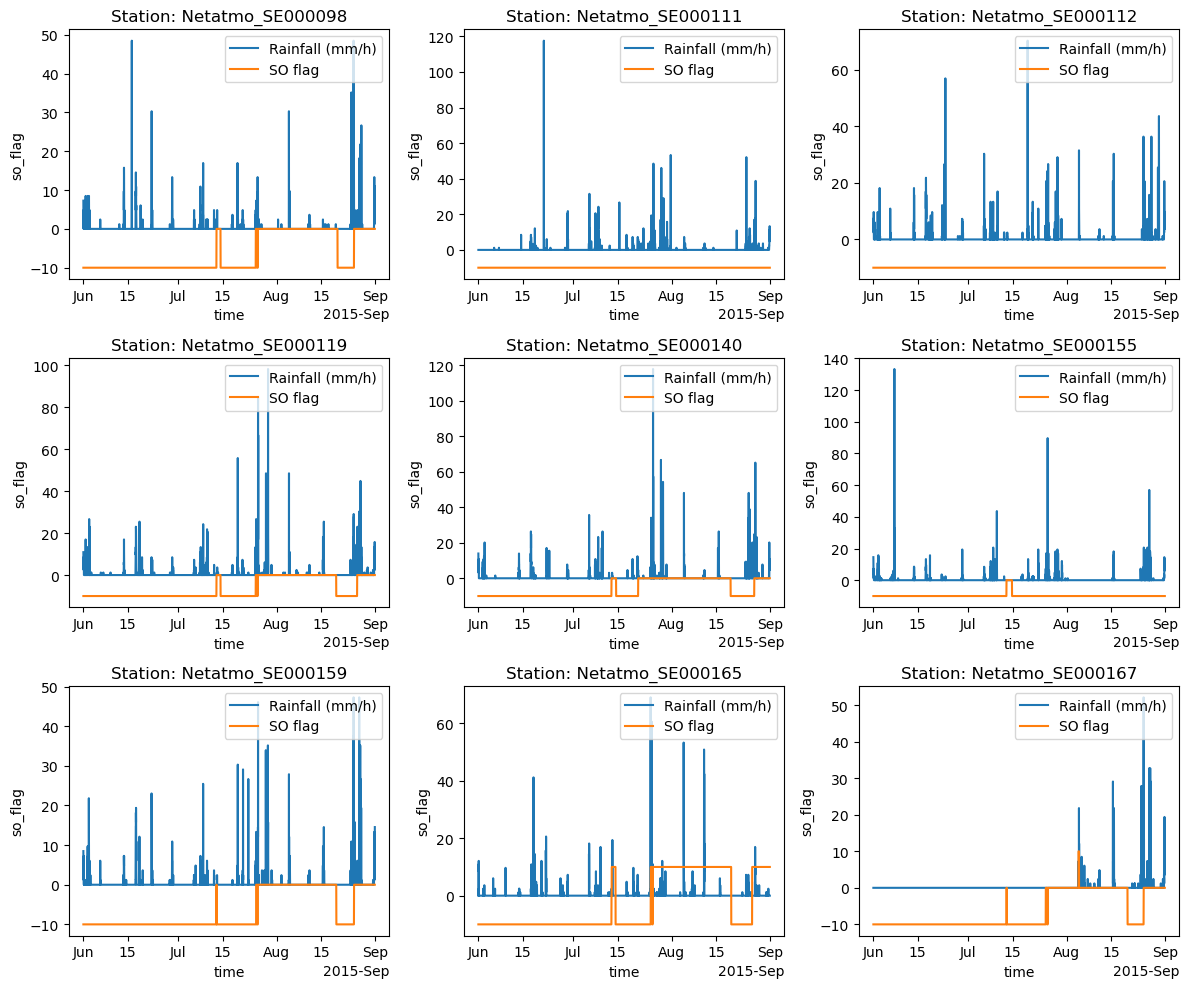

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.flatten()

for j, i in enumerate(np.arange(10, 19)):
    ax = axes[j]
    (ds_pws_flagged.rainfall.isel(id=i) * 12).plot(ax=ax, label="Rainfall (mm/h)")
    (ds_pws_flagged.so_flag.isel(id=i) * 10).plot(ax=ax, label="SO flag")
    ax.legend(loc = "upper right")   
    station_name = ds_pws_flagged.id.values[i]
    ax.set_title(f"Station: {station_name}")

plt.tight_layout()
plt.show()

## Save output

Run the cell below to save the flagged data as NetCDF-file.

In [18]:
ds_pws_flagged.to_netcdf("flagged_dataset.nc")